# Classification de graphes

In [30]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import networkx as nx
import os
import karateclub as kc
import copy

## Construction des graphes pour la classification de graphes

## Prétraitement des données

In [31]:
def preprocessing(gdf, commune, rm_residual_areas=True, object_prop_th=0.50, total_prop_th=0.01):
    assert len(gdf) != 0
    # todo : gérer les nodata
    gdf = gdf.clip(commune["geometry"])

    gdf["total_area"] = gdf.area
    gdf = gdf.drop("Area_Ha", axis="columns")

    gdf = gdf.explode(index_parts=False)
    gdf["object_proportion"] = gdf.area / gdf["total_area"]
    gdf["total_proportion"] = gdf.area / gdf.area.sum()

    if rm_residual_areas is True:
        gdf = gdf[(gdf["object_proportion"] >= object_prop_th) | (gdf["total_proportion"] >= total_prop_th)]

    gdf['Node_ID'] = range(len(gdf))  # pour simplifier la création des graphes
    gdf['Code_18'] = gdf['Code_18'].astype(str)

    return gdf

### Calcul du voisinage

In [32]:
def preprocess_border(border):
    if border.geom_type == "MultiLineString":
        # plusieurs frontières
        border = shapely.ops.linemerge(border)
    return border


def calc_borders(area, neighbors):
    borders_info = {"total_border": [], "greatest_border": [], "nb_borders": []}
    borders = neighbors.geometry.intersection(area.geometry)
    for border in borders:
        border = preprocess_border(border)
        if border.geom_type == "MultiLineString":
            lengths = gpd.GeoSeries(border.geoms).length
            borders_info["total_border"].append(lengths.sum())
            borders_info["greatest_border"].append(max(lengths))
            borders_info["nb_borders"].append(len(lengths))
        else:
            length = border.length
            borders_info["total_border"].append(length)
            borders_info["greatest_border"].append(length)
            borders_info["nb_borders"].append(1)
    return borders_info


def calc_neighbors(gdf):
    neighbors_dict = {"src": [], "dest": [], "total_border": [], "greatest_border": [], "nb_borders": []}

    for index, area in gdf.iterrows():
        neighbors = gdf[gdf.geometry.touches(area.geometry)]
        neighbors = neighbors[~neighbors['Node_ID'].isin(neighbors_dict['src'])]

        dest = neighbors['Node_ID'].tolist()
        src = [area['Node_ID']] * neighbors.shape[0]

        borders = calc_borders(area, neighbors)

        neighbors_dict["src"].extend(src)
        neighbors_dict["dest"].extend(dest)
        neighbors_dict["total_border"].extend(borders["total_border"])
        neighbors_dict["greatest_border"].extend(borders["greatest_border"])
        neighbors_dict["nb_borders"].extend(borders["nb_borders"])

    return neighbors_dict

### Génération des données des graphes

In [33]:
def generate_graph_data(data_path, communes_path):
    graph_properties_dict = {"graph_id": [], "num_nodes": []}
    graph_nodes_dict = {"graph_id": [], "node_id": [], "label": []}
    graph_edges_dict = {"graph_id": [], "src": [], "dest": [], "total_border": [], "greatest_border": [],
                        "nb_borders": []}

    communes = gpd.read_file(communes_path)

    l = len(communes)
    step = int(l * 0.05)
    print(f"Number of instances : {l}")
    i = 1

    for _, commune in communes.iterrows():
        if i % step == 1:
            print(f"{int((i / l) * 100)}%", end="...")

        gdf = preprocessing(gpd.read_file(data_path, mask=commune['geometry']), commune)

        neighbors = calc_neighbors(gdf)

        graph_properties_dict["graph_id"].append(commune['COMM_ID'])
        graph_properties_dict["num_nodes"].append(len(gdf))

        graph_nodes_dict["graph_id"].extend([commune['COMM_ID']] * len(gdf))
        graph_nodes_dict["node_id"].extend(gdf["Node_ID"])
        graph_nodes_dict["label"].extend(gdf["Code_18"])

        graph_edges_dict["src"].extend(neighbors["src"])
        graph_edges_dict["dest"].extend(neighbors["dest"])
        graph_edges_dict["total_border"].extend(neighbors["total_border"])
        graph_edges_dict["greatest_border"].extend(neighbors["greatest_border"])
        graph_edges_dict["nb_borders"].extend(neighbors["nb_borders"])
        graph_edges_dict["graph_id"].extend([commune['COMM_ID']] * len(neighbors["src"]))

        i = i + 1

    print("100%")

    graph_properties_df = pd.DataFrame(graph_properties_dict)
    graph_nodes_df = pd.DataFrame(graph_nodes_dict)
    graph_edges_df = pd.DataFrame(graph_edges_dict)

    return graph_properties_df, graph_nodes_df, graph_edges_df

In [34]:
clc_path = "../data/raw_data/clc/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg"
communes_dir = "../data/communes/comm_17_1800"
communes_path = os.path.join(communes_dir, "communes.gpkg")

In [9]:
graph_properties, graph_nodes, graph_edges = generate_graph_data(clc_path, communes_path)

graph_properties["label"] = graph_properties["graph_id"].str[:2].astype('category').cat.codes

graph_properties.to_csv(os.path.join(communes_dir, "graph_properties.csv"))
graph_nodes.to_csv(os.path.join(communes_dir, "graph_nodes.csv"))
graph_edges.to_csv(os.path.join(communes_dir, "graph_edges.csv"))

Number of instances : 30600
0%...5%...10%...15%...20%...25%...30%...35%...40%...45%...50%...55%...60%...65%...70%...75%...80%...85%...90%...95%...100%


### Quelques statistiques

In [35]:
graph_properties = pd.read_csv(os.path.join(communes_dir, "graph_properties.csv"))
graph_nodes = pd.read_csv(os.path.join(communes_dir, "graph_nodes.csv"))
graph_edges = pd.read_csv(os.path.join(communes_dir, "graph_edges.csv"))

In [36]:
# nombre d'instances
instances = len(graph_properties)
# nombre de classes
classes = len(graph_properties['label'].astype('category').cat.categories)
# nombre de noeuds en moyenne
nodes_groups_sizes = graph_nodes.groupby('graph_id').size()
min_nodes = np.round(nodes_groups_sizes.min(), 2)
mean_nodes = np.round(nodes_groups_sizes.mean(), 2)
max_nodes = np.round(nodes_groups_sizes.max(), 2)
# nombre d'arcs en moyenne
edges_groups_sizes = graph_edges.groupby('graph_id').size()
min_edges = np.round(edges_groups_sizes.min(), 2)
mean_edges = np.round(edges_groups_sizes.mean(), 2)
max_edges = np.round(edges_groups_sizes.max(), 2)
# nombre de labels distincts
labels = len(graph_nodes['label'].astype('category').cat.categories)

In [37]:
print(f"# instances : {instances}")
print(f"# classes : {classes}")
print(f"# nodes (min.) : {min_nodes}")
print(f"# nodes (avg.) : {mean_nodes}")
print(f"# nodes (max.) : {max_nodes}")
print(f"# edges (min.) : {min_edges}")
print(f"# edges (avg.) : {mean_edges}")
print(f"# edges (max.) : {max_edges}")
print(f"# distinct node labels : {labels}")

# instances : 30600
# classes : 17
# nodes (min.) : 1
# nodes (avg.) : 25.22
# nodes (max.) : 597
# edges (min.) : 1
# edges (avg.) : 45.45
# edges (max.) : 1410
# distinct node labels : 44


### Échantillonnage

In [38]:
# création d'un échantillon 5000 instances
ech_properties = graph_properties.sample(frac=1).iloc[:2500]
ech_nodes = graph_nodes[graph_nodes['graph_id'].isin(ech_properties['graph_id'])]
ech_edges = graph_edges[graph_edges['graph_id'].isin(ech_properties['graph_id'])]

In [39]:
# nombre d'instances
instances = len(ech_properties)
# nombre de classes
classes = len(ech_properties['label'].astype('category').cat.categories)
# nombre de noeuds en moyenne
nodes_groups_sizes = ech_nodes.groupby('graph_id').size()
min_nodes = np.round(nodes_groups_sizes.min(), 2)
mean_nodes = np.round(nodes_groups_sizes.mean(), 2)
max_nodes = np.round(nodes_groups_sizes.max(), 2)
# nombre d'arcs en moyenne
edges_groups_sizes = ech_edges.groupby('graph_id').size()
min_edges = np.round(edges_groups_sizes.min(), 2)
mean_edges = np.round(edges_groups_sizes.mean(), 2)
max_edges = np.round(edges_groups_sizes.max(), 2)
# nombre de labels distincts
labels = len(ech_nodes['label'].astype('category').cat.categories)

In [40]:
print(f"# instances : {instances}")
print(f"# classes : {classes}")
print(f"# nodes (min.) : {min_nodes}")
print(f"# nodes (avg.) : {mean_nodes}")
print(f"# nodes (max.) : {max_nodes}")
print(f"# edges (min.) : {min_edges}")
print(f"# edges (avg.) : {mean_edges}")
print(f"# edges (max.) : {max_edges}")
print(f"# distinct node labels : {labels}")

# instances : 2500
# classes : 17
# nodes (min.) : 1
# nodes (avg.) : 25.26
# nodes (max.) : 273
# edges (min.) : 1
# edges (avg.) : 45.69
# edges (max.) : 643
# distinct node labels : 44


### Création des graphes

In [41]:
# NetworkX dataset
class NxClassDataset():
    def __init__(self, properties, nodes, edges):
        self.properties = properties
        self.nodes = nodes
        self.edges = edges
        self.graphs = []
        self.labels = []
        self.ids = []
        self.process()

    def process(self):
        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        for _, row in self.properties.iterrows():
            label_dict[row['graph_id']] = row['label']

        # Group by graph IDs
        edges_group = self.edges.groupby('graph_id')
        nodes_group = self.nodes.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            edges_of_id = edges_group.get_group(graph_id)
            nodes_of_id = nodes_group.get_group(graph_id)
            label = label_dict[graph_id]

            g = nx.Graph(label=label, id=graph_id)
            for _, row in nodes_of_id.iterrows():
                g.add_node(row['node_id'], feature=str(row['label']))
            for _, row in edges_of_id.iterrows():
                g.add_edge(row['src'], row['dest'], total_border=row['total_border'],
                           greatest_border=row['greatest_border'],
                           nb_borders=row['nb_borders'])

            self.graphs.append(g)
            self.labels.append(label)
            self.ids.append(graph_id)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i], self.ids[i]

    def get_graphs(self):
        return self.graphs

    def get_labels(self):
        return self.labels

    def get_ids(self):
        return self.ids

In [42]:
communes_nx_dataset = NxClassDataset(properties=ech_properties,
                                     nodes=ech_nodes,
                                     edges=ech_edges)

### Visualisation des graphes

In [43]:
def draw_map_graph(nx_graph, gdf, column=None, legend=False, ax=None):
    pos = {}
    points = gdf.representative_point()
    for i in range(len(gdf)):
        area = gdf.iloc[i]
        point = points.iloc[i]
        pos[area['Node_ID']] = (point.x, point.y)

    gdf.plot(column, legend=legend, ax=ax)
    nx.draw(nx_graph, pos=pos, with_labels=True, ax=ax, node_color=[(0, 0, 0, 0.7)], font_color="white")

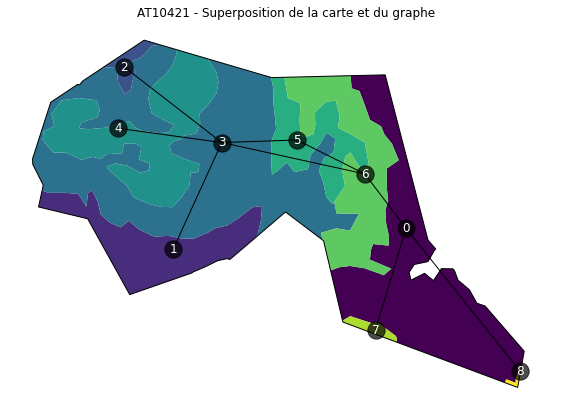

In [17]:
g_nx, g_label, g_id = communes_nx_dataset[5]
f, ax = plt.subplots(figsize=(10, 10))
communes = gpd.read_file(communes_path)
commune = communes[communes['COMM_ID'] == g_id]
gdf = preprocessing(gpd.read_file(clc_path, mask=commune['geometry']), commune)
gdf.dissolve().exterior.plot(ax=ax, color="black", linewidth=1)
draw_map_graph(g_nx, gdf=gdf, column=np.array(range(len(gdf))), ax=ax)
plt.title(f"{g_id} - Superposition de la carte et du graphe")
plt.show()

## Classification des graphes

### Graph embedding

In [18]:
# karate club: https://karateclub.readthedocs.io/en/latest/index.html

In [45]:
graphs = communes_nx_dataset.get_graphs()
labels = np.array(communes_nx_dataset.get_labels())

In [46]:
graph2vec = kc.Graph2Vec(epochs=100, attributed=True)
graph2vec.fit(graphs)

In [47]:
g2v_dataset = graph2vec.get_embedding()
g2v_dataset[0]

array([ 0.27415177, -0.06868446, -0.33472303,  0.24771538, -0.18375176,
        0.03820599,  0.23999217, -0.4497961 , -0.07602786, -0.2599326 ,
       -0.1586671 ,  0.3532228 , -0.4717651 , -0.07908452, -0.24804272,
        0.05634255, -0.19637895, -0.24637312,  0.03120737,  0.09949216,
       -0.176024  ,  0.04759078,  0.23814413, -0.14479268, -0.13971104,
       -0.22142585,  0.05373291, -0.26142   , -0.17738439, -0.21667424,
        0.01573996,  0.09748729,  0.10423452,  0.42197973, -0.20570414,
        0.07837646, -0.09407911,  0.10360274, -0.1166483 ,  0.15702008,
       -0.45479828,  0.11180934, -0.25636026, -0.25739828,  0.01714262,
        0.13495882, -0.29474708,  0.04024161,  0.25722295,  0.1200195 ,
        0.12994874, -0.00948463,  0.10530682, -0.35046506,  0.10401163,
        0.13377522,  0.12778704, -0.1932558 ,  0.10187484,  0.2973681 ,
       -0.05006002,  0.08825461,  0.01903657,  0.24632193,  0.07460295,
       -0.1421827 , -0.03559141,  0.19202293,  0.35961717, -0.06

### Classification

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(g2v_dataset, np.array(labels),
                                                    test_size=0.2)

In [49]:
from tensorflow import keras


def make_model(input_shape):
    return keras.models.Sequential([
        keras.layers.Input(input_shape),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.005)),
        keras.layers.Dropout(rate=0.1),
        keras.layers.Dense(17, activation='softmax')
    ])

In [50]:
model = make_model(X_train[0].shape)

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_7 (Dense)             (None, 17)                289       
                                                                 
Total params: 11,153
Trainable params: 11,153
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.compile(optimizer=keras.optimizers.SGD(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [53]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1000, validation_split=0.2,
                    callbacks=[early_stopping_cb])

Epoch 1/1000
50/50 [==============================] - 1s 5ms/step - loss: 2.9363 - accuracy: 0.0597 - val_loss: 2.9279 - val_accuracy: 0.0352
Epoch 2/1000
50/50 [==============================] - 0s 2ms/step - loss: 2.9241 - accuracy: 0.0478 - val_loss: 2.9177 - val_accuracy: 0.0377
Epoch 3/1000
50/50 [==============================] - 0s 2ms/step - loss: 2.9135 - accuracy: 0.0717 - val_loss: 2.9090 - val_accuracy: 0.0503
Epoch 4/1000
50/50 [==============================] - 0s 2ms/step - loss: 2.9042 - accuracy: 0.0792 - val_loss: 2.9006 - val_accuracy: 0.0528
Epoch 5/1000
50/50 [==============================] - 0s 2ms/step - loss: 2.8979 - accuracy: 0.0862 - val_loss: 2.8927 - val_accuracy: 0.0603
Epoch 6/1000
50/50 [==============================] - 0s 2ms/step - loss: 2.8880 - accuracy: 0.0969 - val_loss: 2.8846 - val_accuracy: 0.0804
Epoch 7/1000
50/50 [==============================] - 0s 2ms/step - loss: 2.8786 - accuracy: 0.1082 - val_loss: 2.8759 - val_accuracy: 0.0879
Epoch 

In [54]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 782us/step - loss: 1.3521 - accuracy: 0.6016


[1.352123737335205, 0.6016096472740173]

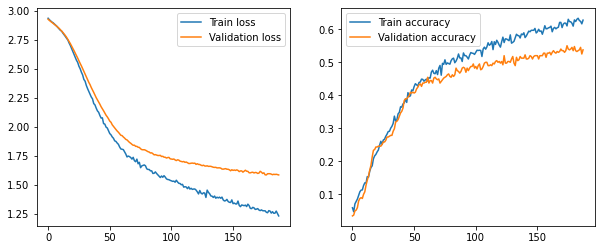

In [55]:
training_loss = history.history['loss']
training_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

import matplotlib.pyplot as plt

f = plt.figure(figsize=(10, 4))
ax = plt.subplot(121)
plt.plot(training_loss, label="Train loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
ax = plt.subplot(122)
plt.plot(training_acc, label="Train accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.legend()
plt.show()

### Hyperparameters tuning

https://colab.research.google.com/drive/12O-bpIrXeMY56lRzkff4S6NQZOgQuu6m?usp=sharing